`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

# Notes:
* In this notebook we shall load a large `NumPy` array directly into RAM to train a model.
* While the model is training keep an eye on the time taken and RAM usage of your machine.
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`. 

# Imports

In [1]:
import sys, os
sys.version

'2.7.17 (default, Jul 20 2020, 15:37:01) \n[GCC 7.5.0]'

In [2]:
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #setting it to -1 hides the GPU.
#tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import IPython
import sys, pickle, os, gzip
import h5py, time, inspect
import IPython.display as display
from keras.utils import to_categorical
import keras, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action='once')
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = InteractiveSession(config=config)
# this make sure thaat if using a gpu total gpu memory is not gobbled
# up by tensorflow and allows growth as required
##https://github.com/tensorflow/tensorflow/issues/24828

Using TensorFlow backend.


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4744988786662804371, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10913778147349097372
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14754229209809221408
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6969917440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14920927984074356755
 physical_device_desc: "device: 0, name: GeForce RTX 2080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
print('TF version:{}, Keras version:{}'.format(tf.__version__, keras.__version__))

TF version:1.15.3, Keras version:2.2.4


# Load the data
* There are `60000` images in the training set and each image needs to be of size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)` indicates number of channels. In this case we have `1` channel because it's a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and `ImageNet` images have `3` channels `(RGB)`. 

In [6]:
filename = 'data/mnist.pkl.gz'
filehandle = gzip.open(filename, 'rb')
train_data, val_data, test_data = pickle.load(filehandle, encoding='latin1')
#train_data, val_data, test_data = pickle.load(filehandle)
filehandle.close()
train_x, train_y = train_data
print('Train data shape:{} and labels shape:{}'.format(train_x.shape, train_y.shape))
val_x, val_y = val_data
print('Valid data shape:{} and labels shape:{}'.format(val_x.shape, val_y.shape))
## combine train and validation data, classifier_class can split it inside 
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
print('Train data shape:{}'.format(train_x.shape))
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print('Train data shape after reshaping:{}'.format(train_x.shape))
print('Train labels shape:{}'.format(train_y.shape))
test_x, test_y = test_data
print('Test data shape:{}'.format(test_x.shape))
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print('Test data shape after reshaping:{}'.format(test_x.shape))
print('Test labels shape:{}'.format(test_y.shape))


Train data shape:(50000, 784) and labels shape:(50000,)
Valid data shape:(10000, 784) and labels shape:(10000,)
Train data shape:(60000, 784)
Train data shape after reshaping:(60000, 28, 28, 1)
Train labels shape:(60000,)
Test data shape:(10000, 784)
Test data shape after reshaping:(10000, 28, 28, 1)
Test labels shape:(10000,)


## One hot vectorize labels

In [7]:
train_y = to_categorical(train_y)
print('Train labels shape:{}'.format(train_y.shape))

test_y = to_categorical(test_y)
print('Test labels shape:{}'.format(test_y.shape))

Train labels shape:(60000, 10)
Test labels shape:(10000, 10)


## Visualize the dataset.

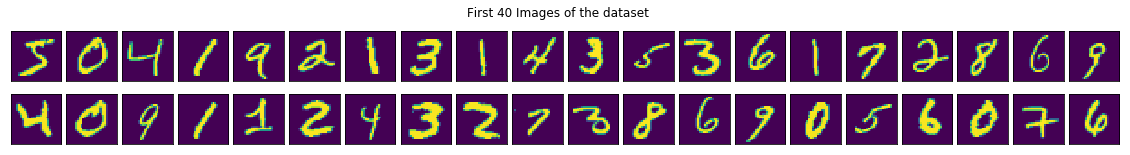

In [8]:
fig, axes = plt.subplots(2, 20, figsize=(20,4), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(left=0.12, bottom=0.5, right=0.89, top=0.9, wspace=0.1, hspace=0.21)
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(train_x[i,:,:,0])
plt.suptitle('First 40 Images of the dataset')
plt.show()

# Setup a small CNN model using `tf.keras.Sequential` 
* A simple convolutional neural network with the structure
* `32c32p64c64p->200->10`
* `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$) set to `0.005`.

In [9]:
eta = 0.0005
val_frac = 0.1 #Fraction of training data to be used for validation 
# FIRST CONVOLUTION LAYER
nC1_kernels = 32 ##number of kernels in the first convolutional layer
C1_kernel_shape = (5, 5) ## size of the kernel in the first convolutional layer (5,5)
C1_stride = 1 ## stride of the convolution
C1_activation = 'relu' ## activation function of the C1 neurons
P1_kernel_shape = (2, 2) ## Size of the pooling window (2,2) 
P1_stride = 2 ## stride of the pooling window

# SECOND CONVOLUTION LAYER
nC2_kernels = 64
C2_kernel_shape = (3, 3)
C2_stride = 1
C2_activation = 'relu'
P2_kernel_shape = (2, 2)
P2_stride = 2

# FULLY CONNECTED LAYER
n_dense = 200
dense_activation = 'relu'

# FINAL LAYER
last_activation = 'softmax'
cost_function = 'categorical_crossentropy'
n_out = 10
optimizer = 'adam' #'sgd'

In [10]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))

#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
model.add(tf.keras.layers.Flatten())

#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               320200    
_________________________________________

## Train the CNN

In [11]:
mini_batch_size = 32
history = model.fit(train_x,train_y, epochs=3, batch_size=mini_batch_size, callbacks=[checkpoint],
                   validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
53824/54000 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9545
Epoch 00001: val_acc improved from -inf to 0.98400, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 5s 94us/sample - loss: 0.1562 - acc: 0.9546 - val_loss: 0.0582 - val_acc: 0.9840
Epoch 2/3
53952/54000 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9849
Epoch 00002: val_acc improved from 0.98400 to 0.98867, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 4s 66us/sample - loss: 0.0474 - acc: 0.9849 - val_loss: 0.0376 - val_acc: 0.9887
Epoch 3/3
53440/54000 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9897
Epoch 00003: val_acc did not improve from 0.98867
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0324 - acc: 0.9897 - val_loss: 0.0419 - val_acc: 0.9877


# Test the model at the end

In [12]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 1s 64us/sample - loss: 0.0310 - acc: 0.9899


[0.031002292409539223, 0.9899]

# Test at the best validation accuracy

In [13]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 0s 10us/sample - loss: 0.0375 - acc: 0.9875


[0.03746303915977478, 0.9875]

# Restart the notebook to free up the `GPU` and `RAM`.

In [14]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'restart': True, 'status': 'ok'}